In [61]:
# parser for ATF files about shuila prayers

## Import packages
from pathlib import Path
import re
import pandas as pd
import numpy as np
import csv
import glob
import spacy
from spacy.symbols import nsubj, VERB, ADJ
from spacy.lang.en import English

# start code for extracting text 
# THIS IS FOR MESOPOTAMIAN SHUILA PRAYERS

nlp = spacy.load("en_core_web_md")

Madjectives = []
Mverbs = []

path = '../EADHproject/shuila/*.atf'
outpath = './shuila/'
for file in glob.glob(path):
    with open(file, encoding='utf-8', errors='ignore') as file_in:
        text = ""
        t = ""
        firstline = file_in.readline()
        #print (firstline)
        # first parse the header code for the text
        header = firstline.split('&')[1].split(" ")[0]  
        # print (header)
        
        # then parse the english text to a simple string
        lines = file_in.readlines()
        for line in lines:
            if "#tr.en:" in line:
                t = line.replace("#tr.en: ", "")
                text = text + " " + t
        # now remove brackets 
        text = text.replace("[", "")
        text = text.replace("]", "")
        # get rid of (parenthetical comments)
        text = re.sub("[\(\[].*?[\)\]]", "", text)
        # remove lots of periods
        text = text.replace(". .", "")
        text = text.replace("  ", " ")
        text = text.replace("\n", " ")
        
        # output cleaned text files.
        with open(outpath + header + '.txt', 'w') as f:
            f.write(text)
        
        #then apply nlp
        
        doc = nlp(text)

        for sent in doc.sents:   #iterate over sentences
            for word in sent:   #iterate over words to find verbs
                if word.pos == VERB:
                    Mverbs.append(word.lemma_)
                if word.pos == ADJ:
                    Madjectives.append(word.lemma_)



In [62]:
# now do PSALMS
Badjectives = []
Bverbs = []

Bpath = '../EADHproject/bible/psalms.txt'
for file in glob.glob(Bpath):
    with open(file, encoding='utf-8', errors='ignore') as file_in:
        text = ""
        result = ""
        
        # then parse the english text to a simple string
        lines = file_in.readlines()
        for line in lines:
            result = ''.join([i for i in line if not i.isdigit()])  #eliminate digits
            text = text + " " + result
        
        # get rid of [(parenthetical comments)]
        text = re.sub("[\(\[].*?[\)\]]", "", text)
        text = text.replace("PSALMS", "")
        # remove lots of periods
        text = text.replace(". .", "")
        text = text.replace("  ", " ")
        text = text.replace("  ", " ")
        text = text.replace("  ", " ")
        
        text = text.replace("\n", " ")
        #print (text)
        # output cleaned text files.
        #with open(outpath + header + '.txt', 'w') as f:
        #    f.write(text)
        
        #then apply nlp
        
        doc = nlp(text)

        for sent in doc.sents:   #iterate over sentences
            for word in sent:   #iterate over words to find verbs
                if word.pos == VERB:
                    Bverbs.append(word.lemma_)
                if word.pos == ADJ:
                    Badjectives.append(word.lemma_)

In [70]:
#convert it to dictionary with values and its occurences
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

Mverb_counts = Counter(Mverbs)
Madj_counts = Counter(Madjectives)
Bverb_counts = Counter(Bverbs)
Badj_counts = Counter(Badjectives)

#  put counts in a dataframe
df_verbs = pd.DataFrame(Bverb_counts.items(), columns = ['verbs', 'Bfrequency'])
df_verbs['Mfrequency'] = df_verbs['verbs'].map(Mverb_counts)  # THIS IS LOSING WORDS THAT ARE NOT PRESENT IN BIBLE!!
df_verbs['Mnormalized'] = df_verbs['Mfrequency']/len(df_verbs)
df_verbs['Bnormalized'] = df_verbs['Bfrequency']/len(df_verbs)

df_adj = pd.DataFrame(Badj_counts.items(), columns = ['adjectives', 'Bfrequency'])
df_adj['Mfrequency'] = df_adj['adjectives'].map(Madj_counts) # THIS IS LOSING WORDS THAT ARE NOT PRESENT IN BIBLE!!
df_adj['Mnormalized'] = df_adj['Mfrequency']/len(df_adj)
df_adj['Bnormalized'] = df_adj['Bfrequency']/len(df_adj)


df_adj.to_csv('../EADHproject/adjective_frequency.csv')
df_verbs.to_csv('../EADHproject/verb_frequency.csv')

In [86]:
# shorten dataframes to keep nonzero value words
df_adj = df_adj.drop(df_adj[df_adj.Mfrequency < 3].index)
df_verbs = df_verbs.drop(df_verbs[df_verbs.Mfrequency < 3].index)

print(df_adj)

    adjectives  Bfrequency  Mfrequency  Mnormalized  Bnormalized
0        happy          10           7     0.020408     0.029155
1       wicked          90          12     0.034985     0.262391
2    righteous          67           8     0.023324     0.195335
4         holy          45           3     0.008746     0.131195
5         wise           9          18     0.052478     0.026239
..         ...         ...         ...          ...          ...
327    anxious           1           3     0.008746     0.002915
328    beloved           1          21     0.061224     0.002915
329  attentive           1          14     0.040816     0.002915
332     bright           1           8     0.023324     0.002915
334    weighty           1           7     0.020408     0.002915

[82 rows x 5 columns]


In [106]:
# measure similarity between words so we can make groups
# output a similarity matrix that compares every word currently in data to every other phrase

# change variable here to switch between adjectives and verbs
d = df_adj

nNodes = d.shape[0]  
similarity_df = pd.DataFrame()
similarity_df = similarity_df.astype(np.float)
sourceList = []
targetList = []
similarityList = []

# Make a giant nSources x nTargets incidence matrix (data frame)
all_sources = list(d.adjectives)   #this needs changing to verbs for the other matrix
all_targets = all_sources

# One row per source
similarity_df = pd.DataFrame(index=np.arange(len(all_sources)), columns=all_targets)
line = -1
for i in similarity_df:
    #print (i)
    line +=1
    for j in similarity_df:      
        source = nlp(i)
        target = nlp(j)
        similarity = source.similarity(target)  #calculate cosine similarity between the two phrases
        similarity_df.at[line,j] = similarity


similarity_df.head()
similarity_df.to_csv("../EADHproject/similarity.csv")


In [135]:
# look for similarity values above some level and output clusters of terms
inverse_similarity_df = similarity_df

from sklearn.decomposition import PCA
 
pca = PCA(2) # we need 2 principal components.  THIS ALGORITHM REDUCES DIMENSION FROM 82 X 82 --> 82 X 2. 
converted_data = pca.fit_transform(inverse_similarity_df)
 
converted_data.shape


(82, 2)

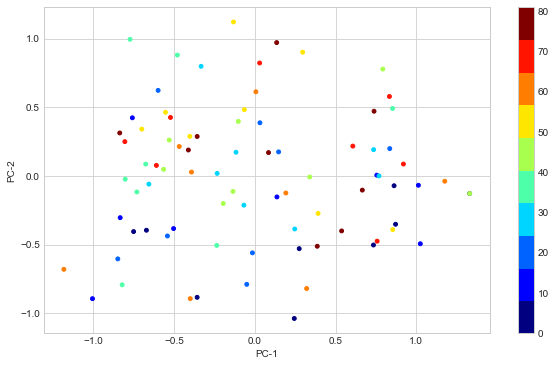

In [136]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = inverse_similarity_df.index)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

In [137]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(converted_data)
  
print(label)  #output the clusters of keywords
x = 0
for x in np.arange(5):
    print (f"cluster {x}")
    for i in np.arange(len(all_sources)):
        if label[i] == x:
            print (all_sources[i])

[4 1 1 1 0 1 4 0 4 4 4 4 1 0 1 1 2 0 2 4 0 0 1 4 3 1 2 3 0 0 2 1 2 3 1 2 0
 3 4 2 2 0 3 1 0 1 2 2 0 1 2 2 3 0 2 3 3 0 4 0 2 2 3 1 4 3 1 1 2 1 2 1 2 2
 0 0 2 0 1 1 2 3]
cluster 0
wise
afraid
weak
human
glad
poor
young
worthy
true
sweet
splendor
old
dead
sick
proud
pleasing
ill
anxious
cluster 1
wicked
righteous
holy
angry
weary
ashamed
awake
divine
noble
mighty
crooked
sanctuary
exalted
evil
merciful
fierce
firstborn
wretched
manifest
beloved
attentive
cluster 2
high
low
pleasant
dark
strong
perfect
clear
fine
clean
such
full
due
new
present
beautiful
first
short
fresh
small
straight
bright
cluster 3
pure
free
broad
wide
acceptable
powerful
firm
radiant
equal
favorable
weighty
cluster 4
happy
many
right
good
own
long
whole
great
sure
bad
well


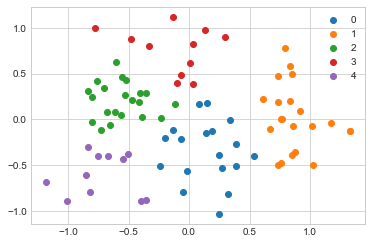

In [141]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(converted_data[label == i , 0] , converted_data[label == i , 1] , label = i)
plt.legend()
plt.show()

[]


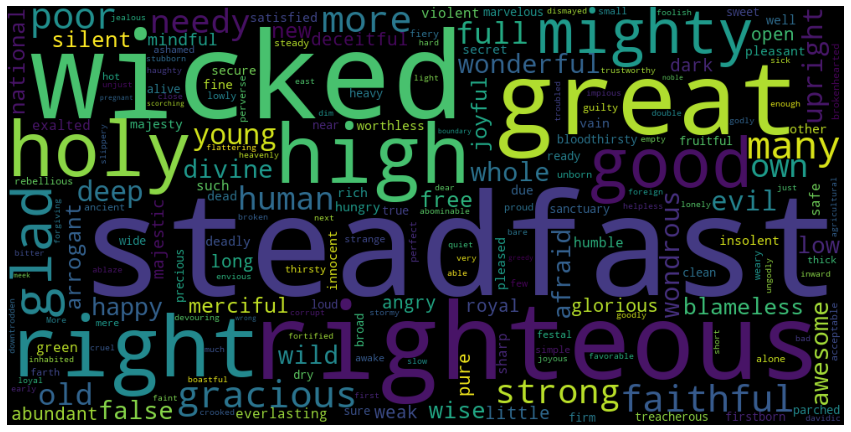

In [81]:
# make wordclouds to see lemma frequency
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(Badj_counts)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
#plt.close()